In [1]:
import random
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# --- Import DEAP ---
from deap import base, creator, tools

In [5]:
df=pd.read_csv("/Users/lubhanamutha/Desktop/Cancer-Prediction-Project/trial2/tcga_preprocessed.csv")
df.head()
df.shape

(10459, 17950)

In [29]:
df.info()
df.describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Columns: 17950 entries, Unnamed: 0 to cancer_type
dtypes: float64(17947), int64(1), object(2)
memory usage: 1.4+ GB


<bound method NDFrame.describe of             Unnamed: 0       7SK      A1BG  A1BG_AS1  A1BG_CTD_2619J13_8  \
0      TCGA-S9-A7J2-01 -0.796991 -0.052854  0.147771            0.078559   
1      TCGA-G3-A3CH-11  0.448863  4.882204  4.685445            5.095249   
2      TCGA-EK-A2RE-01 -0.208117 -0.259900 -0.343978           -0.218950   
3      TCGA-44-6778-01 -0.216039 -0.236235 -0.154341           -0.243607   
4      TCGA-VM-A8C8-01  0.015244 -0.600260 -0.444148           -0.062025   
...                ...       ...       ...       ...                 ...   
10454  TCGA-95-7947-01 -0.240112 -0.553909 -0.595355           -0.453659   
10455  TCGA-VQ-AA6F-01 -0.796991 -0.328610 -0.553237           -0.447750   
10456  TCGA-55-6985-11  0.962167 -0.063219  0.023534            0.065953   
10457  TCGA-DD-A115-01 -0.046462  4.172279  3.856843            4.398265   
10458  TCGA-FV-A3I0-11 -0.047071  5.032143  4.821323            5.351792   

           A1CF       A2M     A2ML1   A2M_AS1    A4GA

In [6]:

# Target column
y = df['cancer_type']

# Drop target column to get features
X_temp = df.drop('cancer_type', axis=1)
X = X_temp.iloc[:, 1:-1]



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

le = LabelEncoder()
# Fit on combined training and test labels
y_combined = np.concatenate((y_train, y_test))
le.fit(y_combined)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

print("Dataset loaded successfully.")
print("shape of dataset",df.shape)
print("shape of x ",X.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Dataset loaded successfully.
shape of dataset (10459, 17950)
shape of x  (10459, 17947)
Shape of X_train: (7321, 17947)
Shape of X_test: (3138, 17947)
Shape of y_train: (7321,)
Shape of y_test: (3138,)


In [7]:
N_FEATURES = X_train.shape[0]

In [14]:
POP_SIZE = 10
N_GENERATIONS = 5
MUTATION_RATE = 0.1
N_FEATURES = X_train.shape[1]
hof = tools.HallOfFame(1)


In [18]:
def initialize_population():
    return np.random.randint(2, size=(POP_SIZE, N_FEATURES))

def fitness(individual):
    selected = [i for i in range(len(individual)) if individual[i] == 1]
    
    if len(selected) < 3:
        return 0.0,  # skip tiny subsets
    
    # --- This is the CORRECT code ---
    X_train_sel = X_train.iloc[:, selected]
    X_test_sel = X_test.iloc[:, selected]
    
    n_classes = len(np.unique(y_train))
    model = XGBClassifier(
        eval_metric="mlogloss",
        objective="multi:softprob",
        num_class=n_classes,
        n_estimators=100,
        max_depth=4,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"   # use CPU for macOS
    )
    
    try:
        model.fit(X_train_sel, y_train)
        preds = model.predict(X_test_sel)
        acc = accuracy_score(y_test, preds)
        return acc,
    except Exception as e:
        print("Error in fitness evaluation:", e)
        return 0.0,
def selection(population, fitnesses):
    idx1, idx2 = random.sample(range(len(population)), 2)
    return population[idx1] if fitnesses[idx1] > fitnesses[idx2] else population[idx2]
def crossover(parent1, parent2):
    point = random.randint(1, N_FEATURES - 1)
    child1 = np.concatenate((parent1[:point], parent2[point:]))
    child2 = np.concatenate((parent2[:point], parent1[point:]))
    return child1, child2
def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]
    return individual


In [19]:
# --- 4. SET UP THE DEAP TOOLBOX ---
# (This was the missing part that caused your error)

# Create the fitness (maximize accuracy) and individual types
# (Weights is (1.0,) for maximizing, (-1.0,) for minimizing)
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

# Initialize the toolbox
toolbox = base.Toolbox()

# Register the "individual" generator
# This creates a single [0, 1, 0, ..., 1] array
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=N_FEATURES)

# Register the "population" generator
# This calls "individual" POP_SIZE times
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# --- Register YOUR functions ---
toolbox.register("evaluate", fitness)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate)

# Use a standard DEAP selection method (Tournament selection is common)
toolbox.register("select", tools.selTournament, tournsize=3)

# --- Define Crossover Probability ---
# (You had MUTATION_RATE defined, but not this)
CROSSOVER_RATE = 0.7


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [22]:



# --- 5. RUN THE GENETIC ALGORITHM ---

print("Starting evolution...")
population = toolbox.population(n=POP_SIZE) 
hof = tools.HallOfFame(1,similar=np.array_equal) # Create the Hall of Fame

# --- Setup Statistics ---
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = "gen", "avg", "max"


Starting evolution...


In [23]:

# --- Evaluate the Initial Population (Gen 0) ---
print("Evaluating initial population...")
fitnesses = map(toolbox.evaluate, population)
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

hof.update(population) # Update HOF with initial data

# Record and print stats for Gen 0
record = stats.compile(population)
logbook.record(gen=0, **record)
print(logbook.stream) # This prints the headers and Gen 0 stats


# --- Run the Generations ---
# (We start at gen 1 since 0 is done)
for gen in range(1, N_GENERATIONS + 1): 
    
    # 1. Select and clone
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # 2. Apply Crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CROSSOVER_RATE:
            toolbox.mate(child1, child2)
            # Invalidate fitness of children after crossover
            del child1.fitness.values 
            del child2.fitness.values

    # 3. Apply Mutation
    for mutant in offspring:
        if random.random() < MUTATION_RATE:
            toolbox.mutate(mutant)
            # Invalidate fitness of mutant
            del mutant.fitness.values 

    # 4. Evaluate all individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    # 5. Replace the old population and update Hall of Fame
    population[:] = offspring
    hof.update(population)
    
    # 6. Record and Print Stats for the Current Generation
    record = stats.compile(population)
    logbook.record(gen=gen, **record)
    print(logbook.stream) # Prints just the stats for the current gen


# --- After the loop, get your final answer ---
best_solution = hof[0]
print("\n--- Evolution Finished ---")
print(f"The best feature set found has an accuracy of: {best_solution.fitness.values[0]:.4f}")

# Optional: Print the details of the best solution
selected_features_indices = [i for i in range(len(best_solution)) if best_solution[i] == 1]
print(f"It selected {len(selected_features_indices)} features out of {N_FEATURES}.")
print("Selected feature indices:", selected_features_indices)

Evaluating initial population...
gen	avg     	max     
0  	0.954908	0.957616
1  	0.956087	0.957935
2  	0.956628	0.957935
3  	0.957425	0.957935
4  	0.957935	0.957935
5  	0.957839	0.957935

--- Evolution Finished ---
The best feature set found has an accuracy of: 0.9579
It selected 8971 features out of 17947.
Selected feature indices: [2, 5, 6, 7, 8, 9, 10, 13, 14, 15, 17, 18, 20, 22, 23, 27, 28, 29, 30, 32, 33, 35, 38, 42, 44, 45, 46, 47, 50, 52, 53, 54, 56, 57, 58, 59, 60, 63, 64, 65, 66, 69, 70, 72, 74, 77, 78, 79, 81, 86, 87, 89, 91, 94, 95, 96, 97, 99, 100, 101, 102, 104, 105, 107, 108, 110, 114, 116, 117, 118, 120, 123, 127, 133, 136, 139, 142, 143, 144, 146, 154, 155, 157, 161, 163, 164, 165, 168, 171, 172, 173, 174, 175, 177, 178, 179, 180, 182, 184, 185, 186, 188, 189, 192, 196, 197, 199, 201, 202, 203, 205, 206, 208, 211, 213, 216, 217, 218, 221, 222, 223, 225, 227, 229, 230, 231, 232, 233, 234, 235, 240, 243, 247, 249, 250, 251, 252, 255, 256, 257, 260, 262, 264, 267, 270, 274

In [24]:
final_fitnesses = np.array([fitness(ind) for ind in population])
best_idx = np.argmax(final_fitnesses)
best_individual = population[best_idx]
selected_features = [i for i in range(N_FEATURES) if best_individual[i] == 1]

print("\n✅ Best Accuracy:", final_fitnesses[best_idx])
print("✅ Selected Feature Indices:", selected_features)
print("✅ Total Features Selected:", len(selected_features))

# Save selected features (if X had column names)
pd.Series(selected_features).to_csv("/Users/lubhanamutha/Desktop/Cancer-Prediction-Project/trial2/ga_selected_features.csv", index=False)
print("Selected features saved to ga_selected_features.csv")



✅ Best Accuracy: [0.95793499]
✅ Selected Feature Indices: [2, 5, 6, 7, 8, 9, 10, 13, 14, 15, 17, 18, 20, 22, 23, 27, 28, 29, 30, 32, 33, 35, 38, 42, 44, 45, 46, 47, 50, 52, 53, 54, 56, 57, 58, 59, 60, 63, 64, 65, 66, 69, 70, 72, 74, 77, 78, 79, 81, 86, 87, 89, 91, 94, 95, 96, 97, 99, 100, 101, 102, 104, 105, 107, 108, 110, 114, 116, 117, 118, 120, 123, 127, 133, 136, 139, 142, 143, 144, 146, 154, 155, 157, 161, 163, 164, 165, 168, 171, 172, 173, 174, 175, 177, 178, 179, 180, 182, 184, 185, 186, 188, 189, 192, 196, 197, 199, 201, 202, 203, 205, 206, 208, 211, 213, 216, 217, 218, 221, 222, 223, 225, 227, 229, 230, 231, 232, 233, 234, 235, 240, 243, 247, 249, 250, 251, 252, 255, 256, 257, 260, 262, 264, 267, 270, 274, 277, 279, 281, 282, 284, 287, 291, 295, 296, 298, 301, 302, 309, 311, 313, 315, 317, 319, 320, 324, 325, 326, 327, 328, 330, 332, 333, 337, 341, 342, 343, 345, 346, 347, 351, 353, 357, 361, 364, 367, 369, 374, 375, 382, 384, 385, 386, 387, 388, 392, 394, 397, 404, 407, 409,

In [27]:
selected_features_mask = best_individual.astype(bool)

# 2. Get the column names of the selected features
selected_gene_names = X.columns[selected_features_mask]

# 3. Create the new, reduced DataFrame of features
X_selected = X[selected_gene_names]

# 4. Combine the selected features with the original 'y' labels
# axis=1 adds the 'y' Series as a new column
final_dataset = pd.concat([X_selected, y], axis=1)

# 5. Save the final dataset to a new CSV
file_path = "/Users/lubhanamutha/Desktop/Cancer-Prediction-Project/trial2/ga_selected_features_and_labels.csv"
final_dataset.to_csv(file_path, index=False)

print(f"Successfully saved {X_selected.shape[1]} features and {len(final_dataset)} samples.")
print(f"Dataset saved to: {file_path}")

Successfully saved 8971 features and 10459 samples.
Dataset saved to: /Users/lubhanamutha/Desktop/Cancer-Prediction-Project/trial2/ga_selected_features_and_labels.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# --- 1. Load Data ---
# Use the file path for the dataset you just created
file_path = "/Users/lubhanamutha/Desktop/Cancer-Prediction-Project/trial2/ga_selected_features_and_labels.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please update the 'file_path' variable to the correct location.")
    exit()

print(f"Dataset loaded successfully. Shape: {df.shape}")

# --- 2. Preprocessing ---

# The user specified: "target is last column and rest all are features"
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# TabNet requires the target 'y' to be numerically encoded (0, 1, 2...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
n_classes = len(le.classes_)

print(f"Target column: '{df.columns[-1]}'")
print(f"Found {n_classes} classes: {le.classes_}")

# Convert features to numpy array (TabNet requirement)
# We assume all features are numerical (gene expression data)
X_numpy = X.to_numpy()

# --- 3. Train, Validation, and Test Split ---
# Deep learning models use a validation set for early stopping.
# We'll do a 70% Train, 15% Validation, 15% Test split.

# First, split into (Train + Val) and Test (85% vs 15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_numpy, y_encoded, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_encoded  # Stratify to keep class balance
)

# Second, split (Train + Val) into Train and Val
# (70% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=(0.15 / 0.85), # 0.15 is 17.6% of 0.85
    random_state=42, 
    stratify=y_train_val
)

print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape:       {X_test.shape}")

# --- 4. Define TabNet Model ---

# Check if CUDA (GPU) is available, otherwise use CPU
device = 'mps' if torch.mps.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize the classifier
# These are some good starting parameters, you can tune them later
clf = TabNetClassifier(
    n_d=32,  # Dimension of the prediction layer
    n_a=32,  # Dimension of the attention layer
    n_steps=5,  # Number of steps in the architecture
    gamma=1.3,  # Coefficient for feature reusage
    n_independent=2, # Number of independent Gated Linear Units
    n_shared=2, # Number of shared Gated Linear Units
    lambda_sparse=1e-3, # Sparse optimization penalty
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax', # 'sparsemax' or 'entmax'
    device_name=device,
    verbose=1 # Print training info
)

# --- 5. Train the Model ---
print("\n--- Starting TabNet Training ---")
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_val, y_val)],
    eval_name=['validation'],
    eval_metric=['accuracy'],
    max_epochs=200,      # Max number of epochs
    patience=20,         # Stop if validation accuracy doesn't improve for 20 epochs
    batch_size=1024,     # Adjust based on your memory
    drop_last=False
)

print("--- Training Finished ---")

# --- 6. Evaluate on Test Set ---
print("\n--- Evaluating on Test Set ---")
preds = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, preds)

print(f"\nTest Set Accuracy: {test_accuracy * 100:.2f}%")

# Print a detailed classification report
# We need to convert the numeric labels back to names for readability
y_test_labels = le.inverse_transform(y_test)
preds_labels = le.inverse_transform(preds)

print("\nClassification Report:")
print(classification_report(y_test_labels, preds_labels))

# --- 7. (Optional) Feature Importances ---
# You can also see which features TabNet thought were most important
print("\n--- Feature Importances ---")
importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df.head(20))

# Save importances to a file
importance_df.to_csv("/Users/lubhanamutha/Desktop/Cancer-Prediction-Project/trial2/tabnet_feature_importances.csv", index=False)
print("\nSaved feature importances to 'tabnet_feature_importances.csv'")


Dataset loaded successfully. Shape: (10459, 8972)
Target column: 'cancer_type'
Found 34 classes: ['TCGA-ACC' 'TCGA-BLCA' 'TCGA-BRCA' 'TCGA-CESC' 'TCGA-CHOL' 'TCGA-COAD'
 'TCGA-DLBC' 'TCGA-ESCA' 'TCGA-GBM' 'TCGA-HNSC' 'TCGA-KICH' 'TCGA-KIRC'
 'TCGA-KIRP' 'TCGA-LAML' 'TCGA-LGG' 'TCGA-LIHC' 'TCGA-LUAD' 'TCGA-LUSC'
 'TCGA-MESO' 'TCGA-OV' 'TCGA-PAAD' 'TCGA-PCPG' 'TCGA-PRAD' 'TCGA-READ'
 'TCGA-SARC' 'TCGA-SKCM' 'TCGA-STAD' 'TCGA-TGCT' 'TCGA-THCA' 'TCGA-THYM'
 'TCGA-UCEC' 'TCGA-UCS' 'TCGA-UVM' nan]
Training set shape:   (7321, 8971)
Validation set shape: (1569, 8971)
Test set shape:       (1569, 8971)
Using device: mps

--- Starting TabNet Training ---


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : mps
  warnings.warn(f"Device used : {self.device}")
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 0  | loss: 4.46434 | validation_accuracy: 0.11281 |  0:00:17s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 1  | loss: 3.72553 | validation_accuracy: 0.116   |  0:00:26s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 2  | loss: 3.34412 | validation_accuracy: 0.16252 |  0:00:35s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 3  | loss: 3.08925 | validation_accuracy: 0.29127 |  0:00:44s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 4  | loss: 2.83642 | validation_accuracy: 0.34927 |  0:00:53s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 5  | loss: 2.59133 | validation_accuracy: 0.35819 |  0:01:04s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 6  | loss: 2.42017 | validation_accuracy: 0.38432 |  0:01:13s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 7  | loss: 2.2882  | validation_accuracy: 0.42575 |  0:01:22s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 8  | loss: 2.24557 | validation_accuracy: 0.36456 |  0:01:32s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 9  | loss: 2.13082 | validation_accuracy: 0.40982 |  0:01:41s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 10 | loss: 2.02322 | validation_accuracy: 0.45188 |  0:01:51s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 11 | loss: 1.89004 | validation_accuracy: 0.49076 |  0:02:00s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 12 | loss: 1.79233 | validation_accuracy: 0.49586 |  0:02:10s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 13 | loss: 1.70684 | validation_accuracy: 0.48311 |  0:02:19s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 14 | loss: 1.55065 | validation_accuracy: 0.55258 |  0:02:28s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 15 | loss: 1.4737  | validation_accuracy: 0.58509 |  0:02:37s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 16 | loss: 1.36769 | validation_accuracy: 0.59783 |  0:02:47s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 17 | loss: 1.32997 | validation_accuracy: 0.59018 |  0:02:57s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 18 | loss: 1.25483 | validation_accuracy: 0.61695 |  0:03:06s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 19 | loss: 1.16039 | validation_accuracy: 0.61122 |  0:03:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 20 | loss: 1.09129 | validation_accuracy: 0.68069 |  0:03:25s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 21 | loss: 1.03528 | validation_accuracy: 0.67113 |  0:03:33s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 22 | loss: 1.00497 | validation_accuracy: 0.68834 |  0:03:43s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 23 | loss: 0.96673 | validation_accuracy: 0.72403 |  0:03:53s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 24 | loss: 0.87646 | validation_accuracy: 0.74187 |  0:04:03s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 25 | loss: 0.83641 | validation_accuracy: 0.72658 |  0:04:13s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 26 | loss: 0.79985 | validation_accuracy: 0.75972 |  0:04:23s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 27 | loss: 0.75665 | validation_accuracy: 0.77565 |  0:04:33s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 28 | loss: 0.71957 | validation_accuracy: 0.78713 |  0:04:42s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 29 | loss: 0.69253 | validation_accuracy: 0.79732 |  0:04:52s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 30 | loss: 0.64625 | validation_accuracy: 0.8037  |  0:05:02s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 31 | loss: 0.61703 | validation_accuracy: 0.80943 |  0:05:12s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 32 | loss: 0.58584 | validation_accuracy: 0.81517 |  0:05:21s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 33 | loss: 0.56413 | validation_accuracy: 0.82282 |  0:05:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 34 | loss: 0.56274 | validation_accuracy: 0.83493 |  0:05:42s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 35 | loss: 0.5206  | validation_accuracy: 0.82855 |  0:05:52s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 36 | loss: 0.50061 | validation_accuracy: 0.82983 |  0:06:01s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 37 | loss: 0.48054 | validation_accuracy: 0.82537 |  0:06:10s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 38 | loss: 0.46961 | validation_accuracy: 0.83301 |  0:06:21s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 39 | loss: 0.47184 | validation_accuracy: 0.84449 |  0:06:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 40 | loss: 0.43597 | validation_accuracy: 0.85277 |  0:06:40s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 41 | loss: 0.4172  | validation_accuracy: 0.85405 |  0:06:49s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 42 | loss: 0.41154 | validation_accuracy: 0.86679 |  0:06:58s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 43 | loss: 0.40946 | validation_accuracy: 0.85723 |  0:07:08s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 44 | loss: 0.37969 | validation_accuracy: 0.86424 |  0:07:17s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 45 | loss: 0.35993 | validation_accuracy: 0.87253 |  0:07:26s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 46 | loss: 0.36718 | validation_accuracy: 0.87126 |  0:07:35s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 47 | loss: 0.35947 | validation_accuracy: 0.85978 |  0:07:44s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 48 | loss: 0.35475 | validation_accuracy: 0.87317 |  0:07:53s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 49 | loss: 0.34513 | validation_accuracy: 0.8566  |  0:08:03s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 50 | loss: 0.34497 | validation_accuracy: 0.87763 |  0:08:13s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 51 | loss: 0.3251  | validation_accuracy: 0.86998 |  0:08:22s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 52 | loss: 0.31905 | validation_accuracy: 0.86488 |  0:08:32s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 53 | loss: 0.31192 | validation_accuracy: 0.8789  |  0:08:41s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 54 | loss: 0.29148 | validation_accuracy: 0.88209 |  0:08:51s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 55 | loss: 0.29817 | validation_accuracy: 0.88209 |  0:09:01s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 56 | loss: 0.32236 | validation_accuracy: 0.87572 |  0:09:11s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 57 | loss: 0.30565 | validation_accuracy: 0.8738  |  0:09:20s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 58 | loss: 0.30183 | validation_accuracy: 0.88846 |  0:09:29s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 59 | loss: 0.28716 | validation_accuracy: 0.88846 |  0:09:38s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 60 | loss: 0.27504 | validation_accuracy: 0.89611 |  0:09:48s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 61 | loss: 0.2656  | validation_accuracy: 0.88846 |  0:09:57s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 62 | loss: 0.26203 | validation_accuracy: 0.88783 |  0:10:06s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 63 | loss: 0.25717 | validation_accuracy: 0.87954 |  0:10:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 64 | loss: 0.25006 | validation_accuracy: 0.8789  |  0:10:23s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 65 | loss: 0.25406 | validation_accuracy: 0.87572 |  0:10:32s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 66 | loss: 0.24338 | validation_accuracy: 0.88273 |  0:10:41s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 67 | loss: 0.23228 | validation_accuracy: 0.89229 |  0:10:50s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 68 | loss: 0.24173 | validation_accuracy: 0.88846 |  0:10:59s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 69 | loss: 0.21506 | validation_accuracy: 0.89611 |  0:11:08s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 70 | loss: 0.21455 | validation_accuracy: 0.8942  |  0:11:17s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 71 | loss: 0.2063  | validation_accuracy: 0.90057 |  0:11:27s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 72 | loss: 0.2131  | validation_accuracy: 0.89484 |  0:11:36s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 73 | loss: 0.20426 | validation_accuracy: 0.90185 |  0:11:45s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 74 | loss: 0.20321 | validation_accuracy: 0.8993  |  0:11:55s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 75 | loss: 0.19968 | validation_accuracy: 0.90376 |  0:12:04s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 76 | loss: 0.19384 | validation_accuracy: 0.9044  |  0:12:13s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 77 | loss: 0.1998  | validation_accuracy: 0.90057 |  0:12:22s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 78 | loss: 0.20587 | validation_accuracy: 0.90504 |  0:12:32s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 79 | loss: 0.19211 | validation_accuracy: 0.90185 |  0:12:42s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 80 | loss: 0.19589 | validation_accuracy: 0.8993  |  0:12:50s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 81 | loss: 0.19061 | validation_accuracy: 0.90121 |  0:13:00s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 82 | loss: 0.19093 | validation_accuracy: 0.90185 |  0:13:09s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 83 | loss: 0.18589 | validation_accuracy: 0.90376 |  0:13:18s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 84 | loss: 0.17209 | validation_accuracy: 0.90631 |  0:13:28s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 85 | loss: 0.17659 | validation_accuracy: 0.90631 |  0:13:37s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 86 | loss: 0.17552 | validation_accuracy: 0.90695 |  0:13:47s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 87 | loss: 0.16939 | validation_accuracy: 0.90822 |  0:13:56s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 88 | loss: 0.16315 | validation_accuracy: 0.91077 |  0:14:05s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 89 | loss: 0.18253 | validation_accuracy: 0.90822 |  0:14:14s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 90 | loss: 0.17122 | validation_accuracy: 0.90567 |  0:14:24s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 91 | loss: 0.16762 | validation_accuracy: 0.9095  |  0:14:34s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 92 | loss: 0.17024 | validation_accuracy: 0.90504 |  0:14:43s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 93 | loss: 0.15584 | validation_accuracy: 0.90631 |  0:14:52s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 94 | loss: 0.15642 | validation_accuracy: 0.90504 |  0:15:01s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 95 | loss: 0.15317 | validation_accuracy: 0.90886 |  0:15:11s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 96 | loss: 0.15347 | validation_accuracy: 0.9095  |  0:15:20s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 97 | loss: 0.14983 | validation_accuracy: 0.91332 |  0:15:29s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 98 | loss: 0.15144 | validation_accuracy: 0.9146  |  0:15:38s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 99 | loss: 0.14803 | validation_accuracy: 0.91332 |  0:15:48s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 100| loss: 0.14752 | validation_accuracy: 0.9146  |  0:15:58s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 101| loss: 0.15043 | validation_accuracy: 0.91332 |  0:16:07s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 102| loss: 0.14234 | validation_accuracy: 0.91013 |  0:16:18s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 103| loss: 0.15027 | validation_accuracy: 0.91587 |  0:16:27s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 104| loss: 0.15694 | validation_accuracy: 0.90758 |  0:16:36s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 105| loss: 0.15062 | validation_accuracy: 0.90822 |  0:16:45s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 106| loss: 0.15076 | validation_accuracy: 0.91396 |  0:16:54s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 107| loss: 0.14277 | validation_accuracy: 0.91332 |  0:17:04s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 108| loss: 0.14094 | validation_accuracy: 0.91396 |  0:17:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 109| loss: 0.13232 | validation_accuracy: 0.91587 |  0:17:24s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 110| loss: 0.14074 | validation_accuracy: 0.91205 |  0:17:34s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 111| loss: 0.13971 | validation_accuracy: 0.91523 |  0:17:45s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 112| loss: 0.13757 | validation_accuracy: 0.91396 |  0:17:55s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 113| loss: 0.13774 | validation_accuracy: 0.91969 |  0:18:04s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 114| loss: 0.14069 | validation_accuracy: 0.90886 |  0:18:13s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 115| loss: 0.13472 | validation_accuracy: 0.91268 |  0:18:22s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 116| loss: 0.13339 | validation_accuracy: 0.91587 |  0:18:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 117| loss: 0.13065 | validation_accuracy: 0.91205 |  0:18:41s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 118| loss: 0.12303 | validation_accuracy: 0.91077 |  0:18:50s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 119| loss: 0.1185  | validation_accuracy: 0.91268 |  0:18:59s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 120| loss: 0.12092 | validation_accuracy: 0.91714 |  0:19:08s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 121| loss: 0.12479 | validation_accuracy: 0.91651 |  0:19:17s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 122| loss: 0.12309 | validation_accuracy: 0.91205 |  0:19:26s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 123| loss: 0.11787 | validation_accuracy: 0.91332 |  0:19:35s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 124| loss: 0.115   | validation_accuracy: 0.91523 |  0:19:45s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 125| loss: 0.11793 | validation_accuracy: 0.91587 |  0:19:54s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 126| loss: 0.11929 | validation_accuracy: 0.91141 |  0:20:03s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 127| loss: 0.11709 | validation_accuracy: 0.91077 |  0:20:12s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 128| loss: 0.11492 | validation_accuracy: 0.91714 |  0:20:21s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 129| loss: 0.11344 | validation_accuracy: 0.91587 |  0:20:30s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 130| loss: 0.11447 | validation_accuracy: 0.91714 |  0:20:39s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 131| loss: 0.1073  | validation_accuracy: 0.91332 |  0:20:48s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 132| loss: 0.10854 | validation_accuracy: 0.91651 |  0:20:57s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 133| loss: 0.11559 | validation_accuracy: 0.91077 |  0:21:06s

Early stopping occurred at epoch 133 with best_epoch = 113 and best_validation_accuracy = 0.91969


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# --- 1. Load Data ---
# Use the file path for the dataset you just created
file_path = "/Users/lubhanamutha/Desktop/Cancer-Prediction-Project/trial2/ga_selected_features_and_labels.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please update the 'file_path' variable to the correct location.")
    exit()

print(f"Dataset loaded successfully. Shape: {df.shape}")

# --- 2. Preprocessing ---

# The user specified: "target is last column and rest all are features"
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# TabNet requires the target 'y' to be numerically encoded (0, 1, 2...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
n_classes = len(le.classes_)

print(f"Target column: '{df.columns[-1]}'")
print(f"Found {n_classes} classes: {le.classes_}")

# Convert features to numpy array (TabNet requirement)
# We assume all features are numerical (gene expression data)
# --- THIS IS THE FIX ---
# Convert directly to np.float32 to be compatible with MPS GPU
X_numpy = X.to_numpy(dtype=np.float32)

# --- 3. Train, Validation, and Test Split ---
# Deep learning models use a validation set for early stopping.
# We'll do a 70% Train, 15% Validation, 15% Test split.

# First, split into (Train + Val) and Test (85% vs 15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_numpy, y_encoded, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_encoded  # Stratify to keep class balance
)

# Second, split (Train + Val) into Train and Val
# (70% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=(0.15 / 0.85), # 0.15 is 17.6% of 0.85
    random_state=42, 
    stratify=y_train_val
)

print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape:       {X_test.shape}")

# --- 4. Define TabNet Model ---

# Check if CUDA (GPU) is available, otherwise use CPU
device = 'mps' if torch.mps.is_available() else 'cpu'
# --- MPS check for Apple Silicon ---
if not torch.mps.is_available() and torch.backends.mps.is_available():
    device = 'mps'
print(f"Using device: {device}")

# Initialize the classifier
# These are some good starting parameters, you can tune them later
clf = TabNetClassifier(
    n_d=32,  # Dimension of the prediction layer
    n_a=32,  # Dimension of the attention layer
    n_steps=5,  # Number of steps in the architecture
    gamma=1.3,  # Coefficient for feature reusage
    n_independent=2, # Number of independent Gated Linear Units
    n_shared=2, # Number of shared Gated Linear Units
    lambda_sparse=1e-3, # Sparse optimization penalty
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax', # 'sparsemax' or 'entmax'
    device_name=device,
    verbose=1 # Print training info
)

# --- 5. Train the Model ---
print("\n--- Starting TabNet Training ---")
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_val, y_val)],
    eval_name=['validation'],
    eval_metric=['accuracy'],
    max_epochs=200,      # Max number of epochs
    patience=20,         # Stop if validation accuracy doesn't improve for 20 epochs
    batch_size=1024,     # Adjust based on your memory
    drop_last=False
)

print("--- Training Finished ---")

# --- 6. Evaluate on Test Set ---
print("\n--- Evaluating on Test Set ---")
preds = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, preds)

print(f"\nTest Set Accuracy: {test_accuracy * 100:.2f}%")

# Print a detailed classification report
# We need to convert the numeric labels back to names for readability
y_test_labels = le.inverse_transform(y_test)
preds_labels = le.inverse_transform(preds)

print("\nClassification Report:")
print(classification_report(y_test_labels, preds_labels))

# --- 7. (Optional) Feature Importances ---
# You can also see which features TabNet thought were most important
print("\n--- Feature Importances ---")
importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df.head(20))

# Save importances to a file
importance_df.to_csv("tabnet_feature_importances.csv", index=False)
print("\nSaved feature importances to 'tabnet_feature_importances.csv'")



Dataset loaded successfully. Shape: (10459, 8972)
Target column: 'cancer_type'
Found 34 classes: ['TCGA-ACC' 'TCGA-BLCA' 'TCGA-BRCA' 'TCGA-CESC' 'TCGA-CHOL' 'TCGA-COAD'
 'TCGA-DLBC' 'TCGA-ESCA' 'TCGA-GBM' 'TCGA-HNSC' 'TCGA-KICH' 'TCGA-KIRC'
 'TCGA-KIRP' 'TCGA-LAML' 'TCGA-LGG' 'TCGA-LIHC' 'TCGA-LUAD' 'TCGA-LUSC'
 'TCGA-MESO' 'TCGA-OV' 'TCGA-PAAD' 'TCGA-PCPG' 'TCGA-PRAD' 'TCGA-READ'
 'TCGA-SARC' 'TCGA-SKCM' 'TCGA-STAD' 'TCGA-TGCT' 'TCGA-THCA' 'TCGA-THYM'
 'TCGA-UCEC' 'TCGA-UCS' 'TCGA-UVM' nan]
Training set shape:   (7321, 8971)
Validation set shape: (1569, 8971)
Test set shape:       (1569, 8971)
Using device: mps

--- Starting TabNet Training ---


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : mps
  warnings.warn(f"Device used : {self.device}")
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 0  | loss: 4.49209 | validation_accuracy: 0.11982 |  0:00:09s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 1  | loss: 3.66247 | validation_accuracy: 0.13639 |  0:00:25s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 2  | loss: 3.28391 | validation_accuracy: 0.20714 |  0:00:35s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 3  | loss: 3.01529 | validation_accuracy: 0.23327 |  0:00:46s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 4  | loss: 2.90594 | validation_accuracy: 0.23646 |  0:00:55s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 5  | loss: 2.79367 | validation_accuracy: 0.28043 |  0:01:07s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 6  | loss: 2.67496 | validation_accuracy: 0.32314 |  0:01:16s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 7  | loss: 2.56809 | validation_accuracy: 0.35437 |  0:01:27s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 8  | loss: 2.44573 | validation_accuracy: 0.36265 |  0:01:36s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 9  | loss: 2.33092 | validation_accuracy: 0.38815 |  0:01:47s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 10 | loss: 2.26653 | validation_accuracy: 0.37667 |  0:01:56s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 11 | loss: 2.15457 | validation_accuracy: 0.40408 |  0:02:06s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 12 | loss: 2.05459 | validation_accuracy: 0.41491 |  0:02:17s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 13 | loss: 2.04329 | validation_accuracy: 0.43021 |  0:16:04s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 14 | loss: 1.95382 | validation_accuracy: 0.4334  |  0:16:22s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 15 | loss: 1.88073 | validation_accuracy: 0.45061 |  0:16:33s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 16 | loss: 1.80249 | validation_accuracy: 0.46208 |  0:16:47s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 17 | loss: 1.75767 | validation_accuracy: 0.5392  |  0:16:59s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 18 | loss: 1.61456 | validation_accuracy: 0.51115 |  0:17:12s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 19 | loss: 1.47297 | validation_accuracy: 0.56214 |  0:17:24s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 20 | loss: 1.33505 | validation_accuracy: 0.61377 |  0:17:34s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 21 | loss: 1.32527 | validation_accuracy: 0.60357 |  0:17:45s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 22 | loss: 1.25493 | validation_accuracy: 0.64691 |  0:17:57s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 23 | loss: 1.17401 | validation_accuracy: 0.65456 |  0:18:07s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 24 | loss: 1.13005 | validation_accuracy: 0.66794 |  0:18:19s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 25 | loss: 1.12464 | validation_accuracy: 0.67686 |  0:18:29s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 26 | loss: 1.08592 | validation_accuracy: 0.68324 |  0:21:56s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 27 | loss: 1.02109 | validation_accuracy: 0.71192 |  0:22:29s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 28 | loss: 0.98721 | validation_accuracy: 0.69535 |  0:23:01s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 29 | loss: 0.91132 | validation_accuracy: 0.73104 |  0:28:43s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 30 | loss: 0.84453 | validation_accuracy: 0.74187 |  0:28:54s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 31 | loss: 0.82115 | validation_accuracy: 0.72339 |  0:29:11s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 32 | loss: 0.79884 | validation_accuracy: 0.73678 |  0:29:22s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 33 | loss: 0.7785  | validation_accuracy: 0.7457  |  0:29:33s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 34 | loss: 0.74323 | validation_accuracy: 0.7731  |  0:29:44s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 35 | loss: 0.69322 | validation_accuracy: 0.77119 |  0:29:55s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 36 | loss: 0.66681 | validation_accuracy: 0.79222 |  0:30:05s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 37 | loss: 0.64414 | validation_accuracy: 0.79732 |  0:30:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 38 | loss: 0.63318 | validation_accuracy: 0.79924 |  0:30:26s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 39 | loss: 0.63663 | validation_accuracy: 0.79605 |  0:30:36s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 40 | loss: 0.61192 | validation_accuracy: 0.79796 |  0:30:45s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 41 | loss: 0.58641 | validation_accuracy: 0.80688 |  0:30:54s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 42 | loss: 0.55094 | validation_accuracy: 0.81198 |  0:31:05s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 43 | loss: 0.55192 | validation_accuracy: 0.81198 |  0:31:14s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 44 | loss: 0.49538 | validation_accuracy: 0.81007 |  0:46:25s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 45 | loss: 0.49341 | validation_accuracy: 0.82091 |  0:46:33s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 46 | loss: 0.49175 | validation_accuracy: 0.82218 |  0:46:44s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 47 | loss: 0.48189 | validation_accuracy: 0.82218 |  1:12:06s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 48 | loss: 0.47056 | validation_accuracy: 0.82983 |  1:12:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 49 | loss: 0.44958 | validation_accuracy: 0.83301 |  1:12:26s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 50 | loss: 0.45445 | validation_accuracy: 0.8464  |  1:12:40s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 51 | loss: 0.43928 | validation_accuracy: 0.83684 |  1:27:51s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 52 | loss: 0.40752 | validation_accuracy: 0.85978 |  1:28:02s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 53 | loss: 0.38226 | validation_accuracy: 0.85277 |  1:28:12s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 54 | loss: 0.35113 | validation_accuracy: 0.85405 |  1:43:22s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 55 | loss: 0.3477  | validation_accuracy: 0.8566  |  1:43:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 56 | loss: 0.33799 | validation_accuracy: 0.8515  |  1:58:42s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 57 | loss: 0.40637 | validation_accuracy: 0.8617  |  1:58:52s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 58 | loss: 0.3977  | validation_accuracy: 0.84704 |  2:14:04s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 59 | loss: 0.38389 | validation_accuracy: 0.84321 |  2:14:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 60 | loss: 0.42786 | validation_accuracy: 0.85277 |  2:14:25s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 61 | loss: 0.40337 | validation_accuracy: 0.84895 |  2:29:36s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 62 | loss: 0.38325 | validation_accuracy: 0.8617  |  2:29:46s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 63 | loss: 0.38752 | validation_accuracy: 0.87253 |  2:47:25s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 64 | loss: 0.33833 | validation_accuracy: 0.88082 |  2:47:35s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 65 | loss: 0.30736 | validation_accuracy: 0.88145 |  2:47:46s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 66 | loss: 0.29175 | validation_accuracy: 0.88209 |  3:02:56s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 67 | loss: 0.29708 | validation_accuracy: 0.884   |  3:03:08s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 68 | loss: 0.28758 | validation_accuracy: 0.88464 |  3:18:20s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 69 | loss: 0.28067 | validation_accuracy: 0.88655 |  3:18:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 70 | loss: 0.26721 | validation_accuracy: 0.88528 |  3:33:24s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 71 | loss: 0.2588  | validation_accuracy: 0.89293 |  3:33:34s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 72 | loss: 0.24688 | validation_accuracy: 0.89165 |  3:48:45s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 73 | loss: 0.26834 | validation_accuracy: 0.88528 |  3:48:56s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 74 | loss: 0.274   | validation_accuracy: 0.88591 |  4:04:07s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 75 | loss: 0.25257 | validation_accuracy: 0.884   |  4:04:19s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 76 | loss: 0.25732 | validation_accuracy: 0.88337 |  4:04:39s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 77 | loss: 0.2673  | validation_accuracy: 0.88337 |  4:04:53s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 78 | loss: 0.26948 | validation_accuracy: 0.87508 |  4:05:04s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 79 | loss: 0.28997 | validation_accuracy: 0.87827 |  4:05:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 80 | loss: 0.25588 | validation_accuracy: 0.88655 |  4:05:26s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 81 | loss: 0.25341 | validation_accuracy: 0.88591 |  4:05:37s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 82 | loss: 0.24149 | validation_accuracy: 0.89101 |  4:05:48s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 83 | loss: 0.22861 | validation_accuracy: 0.89229 |  4:05:59s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 84 | loss: 0.22073 | validation_accuracy: 0.89038 |  4:06:10s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 85 | loss: 0.22568 | validation_accuracy: 0.89484 |  4:06:21s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 86 | loss: 0.21221 | validation_accuracy: 0.8993  |  4:06:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 87 | loss: 0.20523 | validation_accuracy: 0.89675 |  4:06:42s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 88 | loss: 0.20129 | validation_accuracy: 0.90121 |  4:06:55s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 89 | loss: 0.20199 | validation_accuracy: 0.90121 |  4:22:38s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 90 | loss: 0.18356 | validation_accuracy: 0.90312 |  4:22:48s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 91 | loss: 0.18429 | validation_accuracy: 0.90695 |  4:22:58s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 92 | loss: 0.18917 | validation_accuracy: 0.9044  |  4:23:08s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 93 | loss: 0.18954 | validation_accuracy: 0.90312 |  4:38:19s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 94 | loss: 0.18797 | validation_accuracy: 0.90185 |  4:38:28s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 95 | loss: 0.17371 | validation_accuracy: 0.89866 |  4:38:38s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 96 | loss: 0.18566 | validation_accuracy: 0.90567 |  4:38:47s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 97 | loss: 0.1758  | validation_accuracy: 0.90758 |  4:53:58s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 98 | loss: 0.15856 | validation_accuracy: 0.90185 |  4:54:08s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 99 | loss: 0.16823 | validation_accuracy: 0.90185 |  5:09:19s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 100| loss: 0.17137 | validation_accuracy: 0.89802 |  5:09:29s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 101| loss: 0.18301 | validation_accuracy: 0.89038 |  5:24:40s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 102| loss: 0.19289 | validation_accuracy: 0.90376 |  5:24:51s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 103| loss: 0.19001 | validation_accuracy: 0.89675 |  5:40:02s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 104| loss: 0.18508 | validation_accuracy: 0.89547 |  5:40:14s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 105| loss: 0.18014 | validation_accuracy: 0.89675 |  5:46:56s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 106| loss: 0.1654  | validation_accuracy: 0.90312 |  5:47:11s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 107| loss: 0.15203 | validation_accuracy: 0.90567 |  5:47:21s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 108| loss: 0.1556  | validation_accuracy: 0.90249 |  5:47:34s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 109| loss: 0.15146 | validation_accuracy: 0.91077 |  5:48:38s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 110| loss: 0.14976 | validation_accuracy: 0.90758 |  5:48:55s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 111| loss: 0.14081 | validation_accuracy: 0.90886 |  5:49:05s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 112| loss: 0.13765 | validation_accuracy: 0.90822 |  5:49:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 113| loss: 0.13172 | validation_accuracy: 0.91141 |  5:49:25s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 114| loss: 0.12831 | validation_accuracy: 0.90758 |  5:49:39s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 115| loss: 0.14858 | validation_accuracy: 0.89611 |  5:49:49s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 116| loss: 0.1462  | validation_accuracy: 0.90312 |  5:49:59s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 117| loss: 0.12351 | validation_accuracy: 0.91077 |  5:50:10s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 118| loss: 0.14539 | validation_accuracy: 0.89739 |  5:50:20s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 119| loss: 0.18264 | validation_accuracy: 0.90886 |  5:50:30s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 120| loss: 0.13905 | validation_accuracy: 0.90249 |  5:50:41s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 121| loss: 0.13079 | validation_accuracy: 0.90121 |  5:50:51s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 122| loss: 0.12992 | validation_accuracy: 0.90567 |  5:51:02s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 123| loss: 0.12454 | validation_accuracy: 0.91268 |  6:00:09s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 124| loss: 0.12255 | validation_accuracy: 0.91141 |  6:00:21s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 125| loss: 0.11787 | validation_accuracy: 0.91396 |  6:04:56s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 126| loss: 0.11081 | validation_accuracy: 0.90822 |  6:08:48s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 127| loss: 0.10913 | validation_accuracy: 0.91268 |  6:08:58s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 128| loss: 0.1157  | validation_accuracy: 0.90758 |  6:09:09s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 129| loss: 0.12719 | validation_accuracy: 0.90758 |  6:24:21s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 130| loss: 0.11225 | validation_accuracy: 0.91205 |  6:24:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 131| loss: 0.10855 | validation_accuracy: 0.91013 |  6:29:29s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 132| loss: 0.1     | validation_accuracy: 0.91396 |  6:29:42s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 133| loss: 0.09776 | validation_accuracy: 0.9146  |  6:29:54s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 134| loss: 0.10409 | validation_accuracy: 0.91778 |  6:30:03s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 135| loss: 0.09439 | validation_accuracy: 0.91714 |  6:30:19s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 136| loss: 0.09066 | validation_accuracy: 0.91013 |  6:30:34s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 137| loss: 0.09248 | validation_accuracy: 0.91268 |  6:30:49s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 138| loss: 0.08966 | validation_accuracy: 0.91778 |  6:31:02s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 139| loss: 0.08513 | validation_accuracy: 0.92097 |  6:31:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 140| loss: 0.09621 | validation_accuracy: 0.92224 |  6:31:25s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 141| loss: 0.08065 | validation_accuracy: 0.91778 |  6:31:38s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 142| loss: 0.08808 | validation_accuracy: 0.91587 |  6:31:49s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 143| loss: 0.08294 | validation_accuracy: 0.91906 |  6:32:00s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 144| loss: 0.08356 | validation_accuracy: 0.91842 |  6:32:11s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 145| loss: 0.07501 | validation_accuracy: 0.92479 |  6:32:21s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 146| loss: 0.0762  | validation_accuracy: 0.92798 |  6:32:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 147| loss: 0.07207 | validation_accuracy: 0.92798 |  6:32:43s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 148| loss: 0.073   | validation_accuracy: 0.93053 |  6:32:53s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 149| loss: 0.07293 | validation_accuracy: 0.92288 |  6:33:02s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 150| loss: 0.07647 | validation_accuracy: 0.92416 |  6:33:12s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 151| loss: 0.07039 | validation_accuracy: 0.92033 |  6:33:21s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 152| loss: 0.06573 | validation_accuracy: 0.92288 |  6:33:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 153| loss: 0.0681  | validation_accuracy: 0.9267  |  6:33:40s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 154| loss: 0.06689 | validation_accuracy: 0.92543 |  6:38:00s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 155| loss: 0.09031 | validation_accuracy: 0.92033 |  6:38:10s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 156| loss: 0.09287 | validation_accuracy: 0.92161 |  6:38:20s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 157| loss: 0.07514 | validation_accuracy: 0.92161 |  6:38:30s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 158| loss: 0.06737 | validation_accuracy: 0.92543 |  6:38:40s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 159| loss: 0.06932 | validation_accuracy: 0.92543 |  6:38:49s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 160| loss: 0.06479 | validation_accuracy: 0.92352 |  6:38:58s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 161| loss: 0.05915 | validation_accuracy: 0.92543 |  6:39:06s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 162| loss: 0.05749 | validation_accuracy: 0.92862 |  6:39:15s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 163| loss: 0.06094 | validation_accuracy: 0.9318  |  6:39:25s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 164| loss: 0.05859 | validation_accuracy: 0.92862 |  6:39:36s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 165| loss: 0.06059 | validation_accuracy: 0.92479 |  6:39:47s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 166| loss: 0.05942 | validation_accuracy: 0.93117 |  6:39:58s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 167| loss: 0.05269 | validation_accuracy: 0.92925 |  6:40:08s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 168| loss: 0.05594 | validation_accuracy: 0.92989 |  6:47:34s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 169| loss: 0.05823 | validation_accuracy: 0.92288 |  6:47:48s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 170| loss: 0.05877 | validation_accuracy: 0.92607 |  6:47:59s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 171| loss: 0.05489 | validation_accuracy: 0.92416 |  6:48:10s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 172| loss: 0.05533 | validation_accuracy: 0.92543 |  6:48:20s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 173| loss: 0.05181 | validation_accuracy: 0.9267  |  6:48:31s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 174| loss: 0.04935 | validation_accuracy: 0.92798 |  6:48:43s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 175| loss: 0.05062 | validation_accuracy: 0.92862 |  6:48:53s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 176| loss: 0.05287 | validation_accuracy: 0.9267  |  6:49:04s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 177| loss: 0.05166 | validation_accuracy: 0.92862 |  6:49:14s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 178| loss: 0.05133 | validation_accuracy: 0.92862 |  6:49:25s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 179| loss: 0.04894 | validation_accuracy: 0.92734 |  6:49:35s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 180| loss: 0.05282 | validation_accuracy: 0.91969 |  6:49:46s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 181| loss: 0.05432 | validation_accuracy: 0.9267  |  6:49:58s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 182| loss: 0.05127 | validation_accuracy: 0.92352 |  6:53:09s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 183| loss: 0.04978 | validation_accuracy: 0.9267  |  6:53:28s

Early stopping occurred at epoch 183 with best_epoch = 163 and best_validation_accuracy = 0.9318


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


--- Training Finished ---

--- Evaluating on Test Set ---

Test Set Accuracy: 91.84%

Classification Report:


TypeError: '<' not supported between instances of 'str' and 'float'

In [ ]:

# Print a detailed classification report
# We need to convert the numeric labels back to names for readability
y_test_labels = le.inverse_transform(y_test)
preds_labels = le.inverse_transform(preds)

print("\nClassification Report:")
print(classification_report(y_test_labels, preds_labels))

# --- 7. (Optional) Feature Importances ---
# You can also see which features TabNet thought were most important
print("\n--- Feature Importances ---")
importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df.head(20))

# Save importances to a file
importance_df.to_csv("tabnet_feature_importances.csv", index=False)
print("\nSaved feature importances to 'tabnet_feature_importances.csv'")



Generating training history plots...


KeyError: 'val_validation_accuracy'

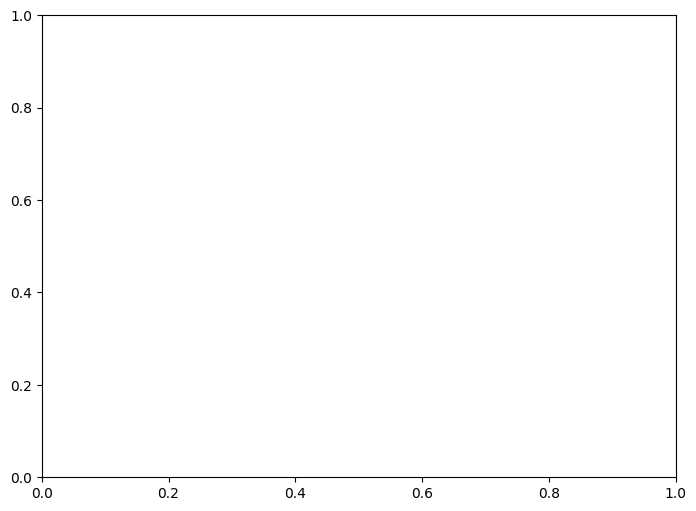

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
    classification_report
)
import numpy as np

# --- 1. PLOT TRAINING HISTORY ---
# This plots the validation accuracy and training loss from the 'clf' object

print("Generating training history plots...")

# Get history from the trained classifier
history = clf.history
epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(18, 6))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history['val_validation_accuracy'], 'b-', label='Validation Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history['loss'], 'r-', label='Training Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --- 2. CALCULATE AND PRINT CORE METRICS ---
# These are the overall scores for your model

print("\n--- Overall Model Performance ---")

# Calculate metrics using 'weighted' average for multi-class
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average='weighted')
recall = recall_score(y_test, preds, average='weighted')
f1 = f1_score(y_test, preds, average='weighted')

print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f} (Weighted)")
print(f"Recall:    {recall:.4f} (Weighted)")
print(f"F1-Score:  {f1:.4f} (Weighted)")


# --- 3. PRINT DETAILED CLASSIFICATION REPORT ---
# This breaks down the scores for each individual cancer type

print("\n--- Detailed Classification Report ---")
# Get class names from the label encoder
class_names = le.classes_
print(classification_report(y_test, preds, target_names=class_names))


# --- 4. PLOT CONFUSION MATRIX ---
# This shows you exactly what the model confused (e.g., "Predicted A" when it was "B")

print("\nGenerating confusion matrix...")

cm = confusion_matrix(y_test, preds)

# Get class names
labels = le.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=labels, 
    yticklabels=labels
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
